<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Overview</a></span><ul class="toc-item"><li><span><a href="#Software-and-conventions" data-toc-modified-id="Software-and-conventions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Software and conventions</a></span></li></ul></li><li><span><a href="#Experiment-with-Deeper-Groundwater-Options" data-toc-modified-id="Experiment-with-Deeper-Groundwater-Options-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Experiment with Deeper Groundwater Options</a></span><ul class="toc-item"><li><span><a href="#Background" data-toc-modified-id="Background-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Background</a></span></li><li><span><a href="#Objective" data-toc-modified-id="Objective-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Objective</a></span></li><li><span><a href="#Step-1:-Create-a-new-template-directory-and-setup-baseline-parameters" data-toc-modified-id="Step-1:-Create-a-new-template-directory-and-setup-baseline-parameters-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Step 1: Create a new template directory and setup baseline parameters</a></span><ul class="toc-item"><li><span><a href="#SLOPE" data-toc-modified-id="SLOPE-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>SLOPE</a></span></li></ul></li><li><span><a href="#Step-2:-Create-and-run-the-&quot;exponential-bucket-model&quot;-simulation" data-toc-modified-id="Step-2:-Create-and-run-the-&quot;exponential-bucket-model&quot;-simulation-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Step 2: Create and run the "exponential bucket model" simulation</a></span></li><li><span><a href="#Step-3:-Create-and-run-the-&quot;groundwater-pass-through&quot;-simulation" data-toc-modified-id="Step-3:-Create-and-run-the-&quot;groundwater-pass-through&quot;-simulation-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Step 3: Create and run the "groundwater pass-through" simulation</a></span></li><li><span><a href="#Step-4:-Create-and-run-the-&quot;groundwater-off&quot;-simulation" data-toc-modified-id="Step-4:-Create-and-run-the-&quot;groundwater-off&quot;-simulation-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Step 4: Create and run the "groundwater off" simulation</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Discussion" data-toc-modified-id="Discussion-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Discussion</a></span></li></ul></li></ul></div>

# Lesson 5b - Groundwater Baseflow Experiments
## Overview
In Lessons 5a we experimented with different terrain routing physics options as well as manipulated a few parameters to evaluate impacts on streamflow. In this lesson we will experiment with different deep groundwater representations in the model

**NOTE: If you have not completed Lessons 1 through 5a, please stop and do so now.**

### Software and conventions
The easiest way to run these lessons is via the [wrfhydro/nwm-training](https://cloud.docker.com/u/wrfhydro/repository/docker/wrfhydro/nwm-training) Docker container, which has all software dependencies and data pre-installed.

For a complete description of the software environment used for this training please see [Lesson 0 - Getting started](Lesson-0-start.ipynb).

You may either execute commands by running each cell of this notebook. Alternatively, you may open a terminal in Jupyter Lab by selecting `New -> Terminal` in your `Home` tab of Jupyter Lab and input the commands manually if you prefer. You can also use your own terminal by logging into the container with the command `docker exec -it nwm-training bash`

All paths used in this lesson assume that the lesson materials are located under your home directory in a folder named `nwm-training`. If your materials are located in another directory, you will not be able to run the commands in this notebook inside Jupyter and will need to type them manually in your terminal session. 

## Experiment with Deeper Groundwater Options
### Background
The current NWM has a uniform 2-meter soil column across the full domain. Obviously the 2-m soil column alone cannot fully represent deeper groundwater processes. For this reason, the code for the current NWM includes a few conceptual ways to very simply represent the slower storage and release processes of deeper groundwater. These include:

0 = No Groundwater Baseflow Model

1 = Exponential Bucket Model

2 = Pass-Through Model

### Objective
Experiment with conceptual groundwater options, then compare hydrographs.

### Step 1: Create a new template directory and setup baseline parameters
We start with the baseline parameters but will modifiy a few to emphasize the deeper baseflow behavior.

**Step 1a: Create a new template directory for the groundwater experiments.**

In [1]:
%%bash
# Make a new directory for our baseline simulation
mkdir -p ~/nwm-training/output/lesson5/run_gw_template

# Copy our model files to the simulation directory
cp ~/nwm-training/wrf_hydro_nwm_public/trunk/NDHMS/Run/*.TBL \
~/nwm-training/output/lesson5/run_gw_template
cp ~/nwm-training/wrf_hydro_nwm_public/trunk/NDHMS/Run/wrf_hydro.exe \
~/nwm-training/output/lesson5/run_gw_template

# Create symbolic links to large domain files
cp -as $HOME/nwm-training/example_case/FORCING \
~/nwm-training/output/lesson5/run_gw_template
cp -as $HOME/nwm-training/example_case/NWM/RESTART \
~/nwm-training/output/lesson5/run_gw_template

# Copy the domain/parameter files so we can modify them
cp -r $HOME/nwm-training/example_case/NWM/DOMAIN \
~/nwm-training/output/lesson5/run_gw_template

# Copy namelist files
cp ~/nwm-training/example_case/NWM/namelist.hrldas \
~/nwm-training/output/lesson5/run_gw_template
cp ~/nwm-training/example_case/NWM/hydro.namelist \
~/nwm-training/output/lesson5/run_gw_template

**Step 1b: Use the NCO command `ncap2` to modify the *slope* parameter values in the `soil_properties.nc` file.**

#### SLOPE
In Lesson 5a we discussed a few Noah/NoahMP parameters that impact flow. We will refresh your memory on the *slope* parameter. Originally estimated based on land surface topography (hence the name *slope*), the *slope* parameter controls how open or closed the bottom boundary of the soil column is. Values range from 0 to 1, where 0 is a completely closed bottom boundary and 1 is completely open. Lower *slope* values will keep more water in the soil column, while higher values will allow more water to drain to the channel or to deeper baseflow stores, depending on the selected physics options.

In order to really emphasize the impacts of the baseflow model experiments, we will completely open up the bottom boundary condition (i.e., free drainage).

We will use NCO commands to manipulate the model parameter files. NCO (NetCDF Operators, http://nco.sourceforge.net/) is a set of useful utilities to manipulate NetCDF files. We will use the NCO command `ncap2` to increase the *slope* value to 1.0.

First, we check the current parameter values using `ncdump` a command line utility included with the netCDF libraries.

In [2]:
%%bash
ncdump -v slope ~/nwm-training/output/lesson5/run_gw_template/DOMAIN/soil_properties.nc \
| tail -n 10

    0.1227628, 0.1227628, 0.1227628, 0.1227628,
  0.06260714, 0.06260714, 0.06260714, 0.1227628, 0.1227628, 0.1227628, 
    0.1227628, 0.1227628, 0.1227628, 0.1227628, 0.1227628, 0.1227628, 
    0.1227628, 0.1227628, 0.1227628, 0.1227628, 0.1227628, 0.1227628, 
    0.1227628, 0.1227628, 0.1227628, 0.1227628,
  0.06321169, 0.06260714, 0.06260714, 0.06260714, 0.06260714, 0.1227628, 
    0.1227628, 0.1227628, 0.1227628, 0.1227628, 0.1227628, 0.1227628, 
    0.1227628, 0.1227628, 0.1227628, 0.1227628, 0.1227628, 0.1227628, 
    0.06260714, 0.06260714, 0.06260714, 0.06260714 ;
}


Note that this parameter varies in space (values based on previous calibration/regionalization), but in general it is fairly low. We modify the parameter values using `ncap2` to completely open the bottom boundary (i.e., free drainage, *slope=1*) and confirm our changes.

In [3]:
%%bash
ncap2 -O -s "slope=slope*0.0+1.0" \
~/nwm-training/output/lesson5/run_gw_template/DOMAIN/soil_properties.nc \
~/nwm-training/output/lesson5/run_gw_template/DOMAIN/soil_properties.nc
ncdump -v slope ~/nwm-training/output/lesson5/run_gw_template/DOMAIN/soil_properties.nc \
| tail -n 10

  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
  1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ;
}


### Step 2: Create and run the "exponential bucket model" simulation
The NWM currently uses the "Exponential Bucket Model" option for groundwater, so we will run that option as our baseline.

**Step 2a: Create a copy of the template directory to use for the first groundwater experiment.**

In [4]:
%%bash
cp -r ~/nwm-training/output/lesson5/run_gw_template \
~/nwm-training/output/lesson5/run_gw_expbucket

**Step 2b: Confirm the groundwater module setting in the namelist is correct**

Look for the `GWBASESWCRT` option and confirm it is set to 1 (exp. bucket).

In [5]:
%%bash
cat ~/nwm-training/output/lesson5/run_gw_expbucket/hydro.namelist

&HYDRO_nlist
!!!! ---------------------- SYSTEM COUPLING ----------------------- !!!!

! Specify what is being coupled:  1=HRLDAS (offline Noah-LSM), 2=WRF, 3=NASA/LIS, 4=CLM
sys_cpl = 1

!!!! ------------------- MODEL INPUT DATA FILES ------------------- !!!!

! Specify land surface model gridded input data file (e.g.: "geo_em.d03.nc")
GEO_STATIC_FLNM = "./DOMAIN/geo_em.d01.nc"

! Specify the high-resolution routing terrain input data file (e.g.: "Fulldom_hires.nc")
GEO_FINEGRID_FLNM = "./DOMAIN/Fulldom_hires.nc"

! Specify the spatial hydro parameters file (e.g.: "hydro2dtbl.nc")
! If you specify a filename and the file does not exist, it will be created for you.
HYDROTBL_F = "./DOMAIN/hydro2dtbl.nc"

! Specify spatial metadata file for land surface grid. (e.g.: "GEOGRID_LDASOUT_Spatial_Metadata.nc")
LAND_SPATIAL_META_FLNM = "./DOMAIN/GEOGRID_LDASOUT_Spatial_Metadata.nc"

! Specify the name of the restart file if starting from restart...comment out with '!' if not...
RESTART_FILE  = 

**Step 2c: Run the simulation and check to make sure it completed successfully**

In [6]:
%%bash
cd ~/nwm-training/output/lesson5/run_gw_expbucket
mpirun -np 1 ./wrf_hydro.exe >> run.log 2>&1

Check that the simulation finished successfully

In [7]:
%%bash
tail -1 ~/nwm-training/output/lesson5/run_gw_expbucket/diag_hydro.00000

 The model finished successfully.......


### Step 3: Create and run the "groundwater pass-through" simulation
Now we will see what happens when we simply allow groundwater to pass directly from the soil column to the channel with no storage/attenuation.

**Step 3a: Create a copy of the Lesson 5 template directory to use for the second groundwater experiment.**

In [8]:
%%bash
cp -r ~/nwm-training/output/lesson5/run_gw_template \
~/nwm-training/output/lesson5/run_gw_passthru

**Step 3b: Edit the `hydro.namelist` file**

We will run the same experiment as the Lesson 5 baseline run, but with the deeper groundwater option changed from the exponential bucket model to a simple pass-through representation.

We will make one modification to `hydro.namelist` to do this. For this experiment, we will set the *GWBASESWCRT* physics option to 2, which is the simple pass-through option. 

```
! Switch to activate baseflow bucket model...(0=none, 1=exp. bucket, 2=pass-through)
GWBASESWCRT = 2
```

**Step 3c: Run the simulation and check to make sure it completed successfully**

In [9]:
%%bash
cd ~/nwm-training/output/lesson5/run_gw_passthru
mpirun -np 1 ./wrf_hydro.exe >> run.log 2>&1

Check that the simulation finished successfully

In [10]:
%%bash
tail -1 ~/nwm-training/output/lesson5/run_gw_passthru/diag_hydro.00000

 The model finished successfully.......


### Step 4: Create and run the "groundwater off" simulation
Now we will repeat the process, but with the deeper groundwater option changed from the exponential bucket model to the "no groundwater" option.

**Step 4a: Create a copy of the Lesson 5 template directory to use for the second groundwater experiment.**

In [11]:
%%bash
cp -r ~/nwm-training/output/lesson5/run_gw_template \
~/nwm-training/output/lesson5/run_gw_off

**Step 4b: Edit the `hydro.namelist` file**

We will make two modifications to `hydro.namelist` to deactivate the groundwater module. For this experiment, we will set the *GWBASESWCRT* physics option to 0, which turns the deeper groundwater module off. 

```
! Switch to activate baseflow bucket model...(0=none, 1=exp. bucket, 2=pass-through)
GWBASESWCRT = 0
```
When the groundwater module is off, the supplemental channel output variables are not permitted. We can simply turn this supplemental output off by setting *output_channelBucket_influx* to 0.

```
! Options to output channel & bucket influxes. Only active for UDMP_OPT=1.
! Nonzero choice requires that out_dt above matches NOAH_TIMESTEP in namelist.hrldas.
! 0=None (default), 1=channel influxes (qSfcLatRunoff, qBucket)
! 2=channel+bucket fluxes    (qSfcLatRunoff, qBucket, qBtmVertRunoff_toBucket)
! 3=channel accumulations    (accSfcLatRunoff, accBucket) *** NOT TESTED ***
output_channelBucket_influx = 0
```

**Step 4c: Run the simulation and check to make sure it completed**

In [12]:
%%bash
cd ~/nwm-training/output/lesson5/run_gw_off
mpirun -np 1 ./wrf_hydro.exe >> run.log 2>&1

Check that the simulation finished successfully

In [13]:
%%bash
tail -1 ~/nwm-training/output/lesson5/run_gw_off/diag_hydro.00000

 The model finished successfully.......


### Results
We will now look at the differences in streamflow between our baseline run with the exponential groundwater bucket module active and our experiments with no groundwater and the simple pass-through module.

We will use Python and the `xarray` library to load the data and plot hydrographs. For an intro to these tools, please see Lesson 3.

**Load the xarray Python package**

In [14]:
# Load the xarray package
%matplotlib inline
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

**Load the CHANOBS streamflow datasets**

We are going to use the CHANOBS files (vs. CHRTOUT files) because it will limit the number of reaches to only those which have a gage.

In [15]:
chanobs_gw_exp = xr.open_mfdataset('/home/docker/nwm-training/output/lesson5/run_gw_expbucket/*CHANOBS*',
                            concat_dim='time')
chanobs_gw_thru = xr.open_mfdataset('/home/docker/nwm-training/output/lesson5/run_gw_passthru/*CHANOBS*',
                            concat_dim='time')
chanobs_gw_off = xr.open_mfdataset('/home/docker/nwm-training/output/lesson5/run_gw_off/*CHANOBS*',
                            concat_dim='time')

obs = pd.read_csv('/home/docker/nwm-training/example_case/USGS_obs.csv',dtype=str)
obs['dateTime'] = pd.to_datetime(obs['dateTime'])
obs['streamflow_cms'] = pd.to_numeric(obs['streamflow_cms'])

**Plot the hydrographs**

/home/docker/miniconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


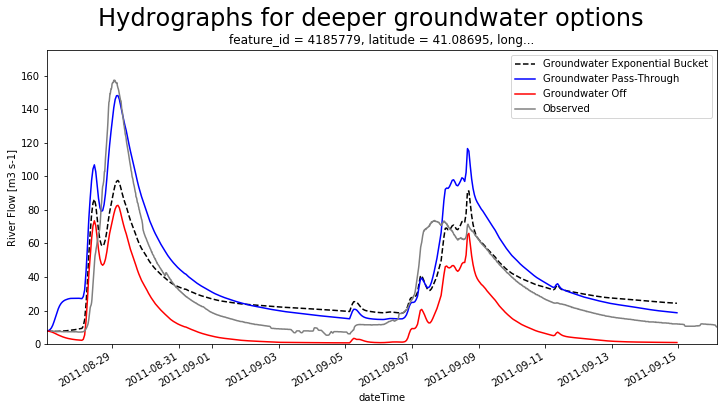

In [16]:
fig, axes = plt.subplots(ncols=1,figsize=(12, 6))
plt.suptitle('Hydrographs for deeper groundwater options',fontsize=24)
chanobs_gw_exp.sel(feature_id = 4185779).streamflow.plot(label='Groundwater Exponential Bucket',
                                                        color='black',
                                                        linestyle='--')
chanobs_gw_thru.sel(feature_id = 4185779).streamflow.plot(label='Groundwater Pass-Through',
                                                        color='blue',
                                                        linestyle='-')
chanobs_gw_off.sel(feature_id = 4185779).streamflow.plot(label='Groundwater Off',
                                                        color='red',
                                                        linestyle='-')

obs[obs['site_no'] == '01447720'].plot(x='dateTime',
                                       y='streamflow_cms',
                                       ax=axes,
                                       label='Observed',
                                       color='grey')
plt.ylim(0,175)
plt.legend()
plt.show()

### Discussion
Since we opened up the bottom boundary of the 2-meter soil column (*slope=1.0*), we are allowing more water to enter into the groundwater module. As a result of this we see more baseflow (with the exception of the groundwater off simulation) and smaller peaks than our earlier simulations, where the *slope* parameter was much smaller (average=0.12) and water tended to stay in the soil column or move to direct runoff.

When comparing the "exponential bucket" model behavior (`GWBASESWCRT=1`, black dashed line) versus "direct pass-through" (`GWBASESWCRT=2`, blue solid line), we see the bucket model tends to store water and slowly release it as baseflow in the lower-flow portions of the hydrograph. The pass-through model moves all that stored water directly to the channel, so the streamflow peaks are higher and the baseflow lower.

When the groundwater baseflow module is deactivated (`GWBASESWCRT=0`), water that drains out of the bottom of the soil column becomes a sink and is not returned to the system. So the "groundwater off" simulation (red solid line) shows lower streamflow overall. Note that this option will not conserve mass, so use with caution.

# Next up - Do it yourself!
This concludes Lesson 5b. Spend some time creating your own parameter and physics experiments.

**IT IS BEST TO EITHER SHUTDOWN THIS LESSON OR CLOSE IT BEFORE PROCEEDING TO THE NEXT LESSON TO AVOID POSSIBLY EXCEEDING ALLOCATED MEMORY. Shutdown the lesson be either closing the browser tab for the lesson or selecting `KERNAL->SHUTDOWN` in the jupyter notebook toolbar.**